In [13]:
import pandas as pd
import json

In [14]:
#medical_reports = pd.read_csv('reports_kk_smaller.csv')
medical_reports = pd.read_csv('reports.csv') # this is domaon specific dataset exaplme which is not axactly available on internet.

In [15]:
medical_reports.head()

,medical_specialty,report
0,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit..."
1,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...
2,Cardiovascular / Pulmonary,"2-D ECHOCARDIOGRAM,Multiple views of the heart..."
3,Cardiovascular / Pulmonary,"DESCRIPTION:,1. Normal cardiac chambers size...."
4,Cardiovascular / Pulmonary,"2-D STUDY,1. Mild aortic stenosis, widely calc..."


# Data processing

In [16]:
## checking missing data
medical_reports.isna().sum()

medical_specialty    0
report               0
dtype: int64

In [18]:
# sequence of fine tuning
# TRAIN --> VALIDATE --> FINAL TEST

In [19]:
medical_reports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2179 entries, 0 to 2178
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   medical_specialty  2179 non-null   object
 1   report             2179 non-null   object
dtypes: object(2)
memory usage: 34.2+ KB


In [20]:
medical_reports.groupby('medical_specialty').count()

,report
medical_specialty,
Cardiovascular / Pulmonary,371
Gastroenterology,224
Neurology,223
Radiology,273
Surgery,1088


In [21]:
medical_reports = medical_reports.dropna(subset=['report']) # drop any missing data

In [22]:
medical_reports.medical_specialty.value_counts()

medical_specialty
Surgery                       1088
Cardiovascular / Pulmonary     371
Radiology                      273
Gastroenterology               224
Neurology                      223
Name: count, dtype: int64

In [23]:
#take a small df to fine tune to save money.longer dataset will cost more credit point
groupedData = medical_reports.groupby('medical_specialty').sample(15,random_state = 42) # Sample 10 items from each class

groupedData['medical_specialty'].value_counts()

medical_specialty
Cardiovascular / Pulmonary    15
Gastroenterology              15
Neurology                     15
Radiology                     15
Surgery                       15
Name: count, dtype: int64

In [24]:
# we have now 10 items of each category.lets take , 6 for traing and 2 for validation and 2 for test


In [25]:
val_test_data = groupedData.groupby('medical_specialty').sample(4,random_state=42) # sample 4 items from the above data

In [26]:
val = val_test_data.groupby('medical_specialty').head(2) # Take the first 2 of each class
test = val_test_data.groupby('medical_specialty').tail(2) # Take the first 2 of each class

train = groupedData[~groupedData.index.isin(val_test_data.index)] # Take the remaining ones for training

In [27]:
len(val_test_data)

20

In [16]:
len(train)

55

In [17]:
# Statistical analysis of custum dataframe

In [18]:
# https://github.com/openai/tiktoken 

In [19]:
# !pip install tiktoken

In [20]:
#lest count number of tokens the model will generate to know pricing of finetuning before fed data into LLM
import tiktoken


In [21]:
# enc = tiktoken.get_encoding("o200k_base") # "o200k_base" enconding is mostly used in gpt llms

In [22]:
def num_tokens(string):
    encoding = tiktoken.get_encoding("cl100k_base") # "o200k_base" enconding is mostly used in gpt llms
    return len(encoding.encode(string))
    
    

In [23]:
num_tokens("Hello")

1

In [24]:
#lets calculate number of tokens in our database
report_token_lenghts = train['report'].apply(num_tokens) # groupedData is the traing data here

In [25]:
report_token_lenghts.describe()

count      55.000000
mean      641.781818
std       471.768685
min        14.000000
25%       265.000000
50%       542.000000
75%       888.500000
max      2362.000000
Name: report, dtype: float64

In [26]:
report_token_lenghts

1841     770
1823     232
2122     806
1865     208
2047     260
1884     531
1927    1502
2113    1307
2041     185
1961     413
1963     306
1616    1551
1666     730
1668      25
1772     352
1760     820
1600     324
1721    1597
1676    1414
1631      14
1800     285
1645     381
1499     593
1472     887
1495    1189
1430     626
1587     832
1441    1103
1504     274
1459     484
1585     673
1433     179
1580     542
1151     161
1367     177
1247     519
1181     390
1293     149
1198     270
1355    1061
1350    1065
1234     214
1235     243
1110     126
1067    1030
144      514
771      713
941      634
940     2362
780      709
705      891
209      890
406      594
1060     944
116      247
Name: report, dtype: int64

In [27]:
sumOfTokens = report_token_lenghts.sum()
sumOfTokens

35298

In [28]:
#lets calculate model price
price_model = 0.00030
total_price_per_epoch = price_model*sumOfTokens


In [29]:
total_priceinINR = total_price_per_epoch*82 /1000 # since price is per 1000 token
total_priceinINR

0.8683308

# Data formatting

In [30]:
#System prompt
#user-report
#assistant-medical_specility
# we want our model to give medical_specility based on report given

In [31]:
print(train['medical_specialty'].unique())

['Cardiovascular / Pulmonary' 'Gastroenterology' 'Neurology' 'Radiology'
 'Surgery']


In [32]:
system_prompt = "Given the medical description report, classify it into one of these categories: Cardiovascular / Pulmonary, Gastroenterology, Neurology, Radiology,Surgery"

In [33]:
print(system_prompt)

Given the medical description report, classify it into one of these categories: Cardiovascular / Pulmonary, Gastroenterology, Neurology, Radiology,Surgery


In [34]:
#example of sample prompt
sample_prompt = {"message" : [{'role':'system','content':system_prompt},
                              {'role':'user','content':train['report'].iloc[0]},
                              {'role':'assistant','content':train['medical_specialty'].iloc[0]}]}

In [35]:
#sample_prompt['message'][1]['content']

In [36]:
print(sample_prompt)

{'message': [{'role': 'system', 'content': 'Given the medical description report, classify it into one of these categories: Cardiovascular / Pulmonary, Gastroenterology, Neurology, Radiology,Surgery'}, {'role': 'user', 'content': 'PREOPERATIVE DIAGNOSES:,1.  Non-small-cell carcinoma of the left upper lobe.,2.  History of lymphoma in remission.,POSTOPERATIVE DIAGNOSES:,1.  Non-small-cell carcinoma of the left upper lobe.,2.  History of lymphoma in remission.,PROCEDURE: , Left muscle sparing mini thoracotomy with left upper lobectomy and mediastinal lymph node dissection.  Intercostal nerve block for postoperative pain relief at five levels.,INDICATIONS FOR THE PROCEDURE: , This is an 84-year-old lady who was referred by Dr. A for treatment of her left upper lobe carcinoma.  The patient has a history of lymphoma and is in remission.  An enlarged right axillary lymph node was biopsied recently and was negative for lymphoma.  A mass in the left upper lobe was biopsied with fine-needle aspi

Lets prepare prompt for complete data

In [37]:
train.head(2)

,medical_specialty,report
1841,Cardiovascular / Pulmonary,"PREOPERATIVE DIAGNOSES:,1. Non-small-cell car..."
1823,Cardiovascular / Pulmonary,"PROCEDURE: , Urgent cardiac catheterization wi..."


In [38]:
def df_to_format(df):
    formatted_data = []
    for index,row in df.iterrows():
        prompt = {"messages" : [{'role' : 'system','content':system_prompt},
                               {'role':'user','content':row['report']},
                               {'role':'assistant','content':row['medical_specialty']}]}
        formatted_data.append(prompt)
    return formatted_data 
        

In [39]:
data = df_to_format(train) # finction call for entire training data

In [40]:
data[20] # one random sample eg index 20

{'messages': [{'role': 'system',
   'content': 'Given the medical description report, classify it into one of these categories: Cardiovascular / Pulmonary, Gastroenterology, Neurology, Radiology,Surgery'},
  {'role': 'user',
   'content': 'PREOPERATIVE DIAGNOSIS: ,  Hematemesis in a patient with longstanding diabetes. ,POSTOPERATIVE DIAGNOSIS:  ,Mallory-Weiss tear, submucosal hemorrhage consistent with trauma from vomiting and grade 2 esophagitis.,PROCEDURE:  , The procedure, indications explained and he understood and agreed.  He was sedated with Versed 3, Demerol 25 and topical Hurricane spray to the oropharynx.  A bite block was placed.  The Pentax video gastroscope was advanced through the oropharynx into the esophagus under direct vision.  Esophagus revealed distal ulcerations.  Additionally, the patient had a Mallory-Weiss tear.  This was subjected to bicap cautery with good ablation.  The stomach was entered, which revealed areas of submucosal hemorrhage consistent with trauma f

In [41]:
# lets dump these list of dictionary into json file to fed into llm

In [42]:
with open('fine_tuning_data.jsonl','w') as f:
    for i in data:
        f.write(json.dumps(i))
        f.write("\n")

In [43]:
#### Lets do the same for validation data
val_data = df_to_format(val)  # finction call for entire validation data
with open('fine_tuning_Val_data.jsonl','w') as f:
    for i in data:
        f.write(json.dumps(i))
        f.write("\n")

In [44]:
# tuning llm

In [7]:
import openai
import os

In [8]:
print(openai.__version__)

1.39.0


In [9]:
from openai import OpenAI

In [10]:
#adding connetion with environment variable(recommeneded)
os.environ['OPENAI_API_KEY'] = 'OPENAI_API_KEY' 

In [11]:
client = OpenAI()

# use of base model-(without fine tuning)

In [50]:

#lesser price model
completion = client.chat.completions.create(
    model = 'gpt-4o-mini-2024-07-18',
    messages = [
        { "role": "system","content": "You are a helpful assistant."},
        { "role": "user","content": "Tell me about India"}
    ]
)

In [51]:
print(completion.choices[0].message.content)

India, officially known as the Republic of India, is a country located in South Asia. It is the seventh-largest country by land area and the second-most populous country in the world, with over 1.4 billion people. Here are some key aspects of India:

### Geography:
- **Location**: Bordered by Pakistan to the northwest, China and Nepal to the north, and Bhutan to the northeast. To the south, it is surrounded by the Indian Ocean, with the Arabian Sea to the southwest and the Bay of Bengal to the southeast.
- **Diversity**: India has a diverse landscape that includes mountains (the Himalayas in the north), deserts (the Thar Desert in the northwest), plains, forests, and extensive coastlines.

### History:
- **Ancient Civilization**: India is home to one of the world's oldest civilizations, the Indus Valley Civilization, which dates back to around 2500 BCE.
- **Empires**: Throughout its history, India has been ruled by various dynasties and empires, including the Maurya, Gupta, Mughal, and

# tuning base model

In [52]:
#uploading tuning data to LLM model
file_upload_response = client.files.create(file = open('fine_tuning_data.jsonl','rb'),purpose='fine-tune')

In [53]:
#checking whether our traing data uploaded onto llm
file_upload_response

FileObject(id='file-Mjt3EsKNXD8jKkxbAZkiolNI', bytes=163613, created_at=1723621727, filename='fine_tuning_data.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [54]:
#uploading validation data to LLM model
file_upload_reponse_val = client.files.create(file = open('fine_tuning_Val_data.jsonl','rb'),purpose= 'fine-tune' )

In [55]:
#checking whether our val data uploaded onto llm
file_upload_reponse_val

FileObject(id='file-sSh4wjRwzIQ62xkOsboGxLs4', bytes=163613, created_at=1723621728, filename='fine_tuning_Val_data.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [56]:
# Lets start training process
fine_tuning_response = client.fine_tuning.jobs.create(model = 'gpt-3.5-turbo',training_file = file_upload_response.id,validation_file = file_upload_reponse_val.id,hyperparameters={'n_epochs':1})

In [57]:
fine_tuning_response

FineTuningJob(id='ftjob-IRnssDdpz975XPmgkGVitGPw', created_at=1723621730, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs=1, batch_size='auto', learning_rate_multiplier='auto'), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-mbNcPYpGizZygum1XP4qz4yt', result_files=[], seed=241626631, status='validating_files', trained_tokens=None, training_file='file-Mjt3EsKNXD8jKkxbAZkiolNI', validation_file='file-sSh4wjRwzIQ62xkOsboGxLs4', estimated_finish=None, integrations=[], user_provided_suffix=None)

In [58]:
client.fine_tuning.jobs.list()

SyncCursorPage[FineTuningJob](data=[FineTuningJob(id='ftjob-IRnssDdpz975XPmgkGVitGPw', created_at=1723621730, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs=1, batch_size='auto', learning_rate_multiplier='auto'), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-mbNcPYpGizZygum1XP4qz4yt', result_files=[], seed=241626631, status='validating_files', trained_tokens=None, training_file='file-Mjt3EsKNXD8jKkxbAZkiolNI', validation_file='file-sSh4wjRwzIQ62xkOsboGxLs4', estimated_finish=None, integrations=[], user_provided_suffix=None), FineTuningJob(id='ftjob-00sEXw4wSVoGo87QTyeFD5I7', created_at=1723536596, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:gpt-3.5-turbo-0125:personal::9vgwwtrB', finished_at=1723536820, hyperparameters=Hyperparameters(n_epochs=1, batch_size=1, learning_rate_multiplier=2), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organ

In [64]:
client.fine_tuning.jobs.list(limit =1)

SyncCursorPage[FineTuningJob](data=[FineTuningJob(id='ftjob-IRnssDdpz975XPmgkGVitGPw', created_at=1723621730, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:gpt-3.5-turbo-0125:personal::9w37hVUP', finished_at=1723622056, hyperparameters=Hyperparameters(n_epochs=1, batch_size=1, learning_rate_multiplier=2), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-mbNcPYpGizZygum1XP4qz4yt', result_files=['file-5IapiYpAVViSTbCviBUcvVMb'], seed=241626631, status='succeeded', trained_tokens=37960, training_file='file-Mjt3EsKNXD8jKkxbAZkiolNI', validation_file='file-sSh4wjRwzIQ62xkOsboGxLs4', estimated_finish=None, integrations=[], user_provided_suffix=None)], object='list', has_more=True)

# Visualize and grab fine tuning event data 

## Visualiziing losses

In [68]:
train_event = client.fine_tuning.jobs.list_events(fine_tuning_job_id='ftjob-IRnssDdpz975XPmgkGVitGPw',limit=55)

In [69]:
train_event.data # returns a list of all fine tuning job events

[FineTuningJobEvent(id='ftevent-YDu7nfXCIbSMsJfEoUq69jOX', created_at=1723622060, level='info', message='The job has successfully completed', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-XGZ6bnCwOSLRh0HUUOixIflq', created_at=1723622058, level='info', message='New fine-tuned model created: ft:gpt-3.5-turbo-0125:personal::9w37hVUP', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-7Al5C6lG6tCdnp8P3b90Haa6', created_at=1723622046, level='info', message='Step 55/55: training loss=0.00, validation loss=0.00, full validation loss=0.27', object='fine_tuning.job.event', data={'step': 55, 'train_loss': 4.19616708313697e-06, 'valid_loss': 1.1920928955078125e-05, 'total_steps': 55, 'full_valid_loss': 0.26852442680384575, 'train_mean_token_accuracy': 1.0, 'valid_mean_token_accuracy': 1.0, 'full_valid_mean_token_accuracy': 0.9595959595959596}, type='metrics'),
 FineTuningJobEvent(id='ftevent-Ax26P1aUqH6xMzmEnDOO83

In [70]:
train_event.data[0]

FineTuningJobEvent(id='ftevent-YDu7nfXCIbSMsJfEoUq69jOX', created_at=1723622060, level='info', message='The job has successfully completed', object='fine_tuning.job.event', data={}, type='message')

looks like above message is last message saying that jb completed

In [71]:
train_event.data[1]

FineTuningJobEvent(id='ftevent-XGZ6bnCwOSLRh0HUUOixIflq', created_at=1723622058, level='info', message='New fine-tuned model created: ft:gpt-3.5-turbo-0125:personal::9w37hVUP', object='fine_tuning.job.event', data={}, type='message')

In [72]:
train_event.data[2]

FineTuningJobEvent(id='ftevent-7Al5C6lG6tCdnp8P3b90Haa6', created_at=1723622046, level='info', message='Step 55/55: training loss=0.00, validation loss=0.00, full validation loss=0.27', object='fine_tuning.job.event', data={'step': 55, 'train_loss': 4.19616708313697e-06, 'valid_loss': 1.1920928955078125e-05, 'total_steps': 55, 'full_valid_loss': 0.26852442680384575, 'train_mean_token_accuracy': 1.0, 'valid_mean_token_accuracy': 1.0, 'full_valid_mean_token_accuracy': 0.9595959595959596}, type='metrics')

In [73]:
train_event.data[2].data # o/p of this is a dictionary

{'step': 55,
 'train_loss': 4.19616708313697e-06,
 'valid_loss': 1.1920928955078125e-05,
 'total_steps': 55,
 'full_valid_loss': 0.26852442680384575,
 'train_mean_token_accuracy': 1.0,
 'valid_mean_token_accuracy': 1.0,
 'full_valid_mean_token_accuracy': 0.9595959595959596}

In [74]:
#lets capture thses data 
train_loss = []
valid_loss = []

for item in train_event.data:
    train_data = item.data
    if train_data and 'train_loss' in train_data:
        train_loss.insert(0,train_data['train_loss'])
        valid_loss.insert(0,train_data['valid_loss'])
    
    

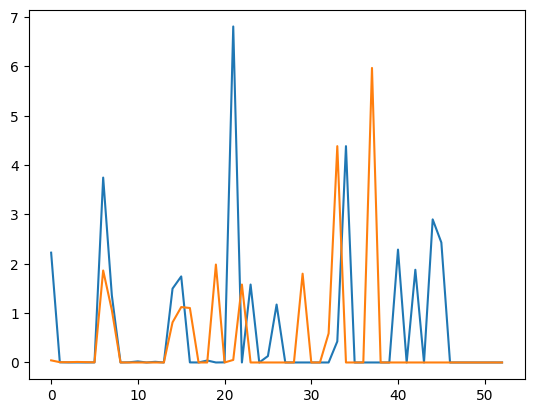

In [75]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(train_loss)
plt.plot(valid_loss)

# apply fine tuned mode now !

In [12]:
#example model
completion = client.chat.completions.create(
    model = 'gpt-4o-mini-2024-07-18',
    messages = [
        { "role": "system","content": "You are a helpful assistant."},
        { "role": "user","content": "Tell me about India"}
    ]
)

In [35]:
test_report = test['report'].iloc[1]

In [48]:
system_prompt = "Given the medical description report, classify it into one of these categories: Cardiovascular / Pulmonary, Gastroenterology, Neurology, Radiology,Surgery"
completion = client.chat.completions.create(model = 'ft:gpt-3.5-turbo-0125:personal::9w37hVUP',
                                           messages = [
                                               {'role':'system','content':system_prompt},
                                               {'role':'user','content':test_report}
                                           ]) # here we are putting our fine tuned model

In [50]:
print(completion)

ChatCompletion(id='chatcmpl-9wUd0e4qEMlRV614SIgdEQ7U9P5H3', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Surgery', role='assistant', function_call=None, tool_calls=None, refusal=None))], created=1723727786, model='ft:gpt-3.5-turbo-0125:personal::9w37hVUP', object='chat.completion', service_tier=None, system_fingerprint=None, usage=CompletionUsage(completion_tokens=2, prompt_tokens=352, total_tokens=354))


In [51]:
completion.choices[0].message

ChatCompletionMessage(content='Surgery', role='assistant', function_call=None, tool_calls=None, refusal=None)

In [53]:
completion.choices[0].message.content

'Surgery'

In [38]:
type(completion)

openai.types.chat.chat_completion.ChatCompletion

In [ ]:
# lets put test dat in loop to check how many correct answer our tuned model give

In [55]:
test = test.head(3) # make test data small

In [66]:
#function to get output from LLM
def classify_report(report,model):
    completion = client.chat.completions.create(model = model,
                                           messages = [
                                               {'role':'system','content':system_prompt},
                                               {'role':'user','content':report}
                                           ]) # here we are putting our fine tuned model
    return completion

## check on base model

In [81]:
predicted_classes = []
ground_truth_classes = []
for index,row in test.iterrows():
    report, specialty = row['report'],row['medical_specialty']
    ground_truth_classes.append(specialty.strip())
    prediction = classify_report(report, model = 'gpt-4o-mini-2024-07-18')
    predicted_classes.append(prediction.choices[0].message.content.strip())
    
    

predicted_classes = []
ground_truth_classes = []
for line in test.iterrows():
    report, specialty = line[1]['report'],line[1]['medical_specialty']
    print(report,specialty)
    ground_truth_classes.append(specialty.strip())
    prediction = classify_report(report, model = 'gpt-4o-mini-2024-07-18')
    predicted_classes.append(prediction.choices[0].message.content.strip())
    
    

In [77]:
import numpy as np
(np.array(predicted_classes) == np.array(ground_truth_classes)).mean() # ACCuracy

0.0

## check on tuned model

In [72]:
predicted_classes = []
ground_truth_classes = []
for index,row in test.iterrows():
    report, specialty = row['report'],row['medical_specialty']
    ground_truth_classes.append(specialty.strip())
    prediction = classify_report(report, model = 'ft:gpt-3.5-turbo-0125:personal::9w37hVUP')
    predicted_classes.append(prediction.choices[0].message.content.strip())
    
    

In [73]:
import numpy as np
(np.array(predicted_classes) == np.array(ground_truth_classes)).mean() # ACCuracy

0.3333333333333333

In [74]:
ground_truth_classes

['Cardiovascular / Pulmonary',
 'Cardiovascular / Pulmonary',
 'Gastroenterology']

In [75]:
predicted_classes

['Surgery', 'Surgery', 'Gastroenterology']

# Other analysis

# #lets check the format of traing data

In [60]:

data_path = r"C:\Users\ekrsinh\OneDrive - Ericsson\Documents\LLM\LLM Fine-Tuning on OpenAI/fine_tuning_Val_data.jsonl"

# Load the dataset
with open(data_path, 'r', encoding='utf-8') as f:
    dataset = [json.loads(line) for line in f]

# Initial dataset stats
print("Num examples:", len(dataset))
print("First example:")
for message in dataset[0]["messages"]:
    print(message)

Num examples: 55
First example:
{'role': 'system', 'content': 'Given the medical description report, classify it into one of these categories: Cardiovascular / Pulmonary, Gastroenterology, Neurology, Radiology,Surgery'}
{'role': 'user', 'content': 'PREOPERATIVE DIAGNOSES:,1.  Non-small-cell carcinoma of the left upper lobe.,2.  History of lymphoma in remission.,POSTOPERATIVE DIAGNOSES:,1.  Non-small-cell carcinoma of the left upper lobe.,2.  History of lymphoma in remission.,PROCEDURE: , Left muscle sparing mini thoracotomy with left upper lobectomy and mediastinal lymph node dissection.  Intercostal nerve block for postoperative pain relief at five levels.,INDICATIONS FOR THE PROCEDURE: , This is an 84-year-old lady who was referred by Dr. A for treatment of her left upper lobe carcinoma.  The patient has a history of lymphoma and is in remission.  An enlarged right axillary lymph node was biopsied recently and was negative for lymphoma.  A mass in the left upper lobe was biopsied wit

In [61]:
# check type of error in traing data


In [62]:
import json
import tiktoken # for token counting
import numpy as np
from collections import defaultdict

In [63]:
# Format error checks
format_errors = defaultdict(int)

for ex in dataset:
    if not isinstance(ex, dict):
        format_errors["data_type"] += 1
        continue
        
    messages = ex.get("messages", None)
    if not messages:
        format_errors["missing_messages_list"] += 1
        continue
        
    for message in messages:
        if "role" not in message or "content" not in message:
            format_errors["message_missing_key"] += 1
        
        if any(k not in ("role", "content", "name", "function_call", "weight") for k in message):
            format_errors["message_unrecognized_key"] += 1
        
        if message.get("role", None) not in ("system", "user", "assistant", "function"):
            format_errors["unrecognized_role"] += 1
            
        content = message.get("content", None)
        function_call = message.get("function_call", None)
        
        if (not content and not function_call) or not isinstance(content, str):
            format_errors["missing_content"] += 1
    
    if not any(message.get("role", None) == "assistant" for message in messages):
        format_errors["example_missing_assistant_message"] += 1

if format_errors:
    print("Found errors:")
    for k, v in format_errors.items():
        print(f"{k}: {v}")
else:
    print("No errors found")

No errors found
